In [1]:
### TEST
import os
import sys
from pathlib import Path

nb_dir = Path(os.getcwd())

# 프로젝트 루트: notebooks/Jang -> notebooks -> project_root
project_root = nb_dir.parents[1]  # /data/ephemeral/pro-nlp-generationfornlp-nlp-13

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("project_root:", project_root)
print("sys.path[0]:", sys.path[0])

project_root: /data/ephemeral/pro-nlp-generationfornlp-nlp-13
sys.path[0]: /data/ephemeral/pro-nlp-generationfornlp-nlp-13


In [2]:
# 학습 시 사용했던 config 그대로 로드
import yaml
from pathlib import Path
from transformers import AutoTokenizer
from src.data.data_loader import DataConfig, make_train_valid_dataset
from src.prompt.prompt_builder import PromptConfig
from src.data.tokenizer_wrapper import TokenizerConfig

project_root = Path("/data/ephemeral/pro-nlp-generationfornlp-nlp-13")

with open(project_root / "config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

data_cfg = DataConfig(
    train_path=str(project_root / "data/train.csv"),
    test_path=str(project_root / "data/test.csv"),
    valid_ratio=cfg["data"]["valid_ratio"],  # 0.1
    seed=cfg["data"]["seed"],  # 42
    do_split=cfg["data"]["do_split"],  # True
)

prompt_cfg = PromptConfig(
    templates_dir=str(project_root / "src/prompt/templates"),
    verbose=cfg["prompt"]["verbose"],
    policy=cfg["prompt"]["policy"],
)

tokenize_cfg_train = TokenizerConfig(
    max_length=cfg["tokenizer"]["train"]["max_length"],  # 2048
    padding=cfg["tokenizer"]["train"]["padding"],  # False
    truncation=cfg["tokenizer"]["train"]["truncation"],  # True
    add_generation_prompt=cfg["tokenizer"]["train"]["add_generation_prompt"],  # False
)

tokenize_cfg_gen = TokenizerConfig(
    max_length=cfg["tokenizer"]["gen"]["max_length"],  # 2048
    padding=cfg["tokenizer"]["gen"]["padding"],  # "max_length"
    truncation=cfg["tokenizer"]["gen"]["truncation"],  # True
    add_generation_prompt=cfg["tokenizer"]["gen"]["add_generation_prompt"],  # True
)

model_name = cfg["model"]["model_name_or_path"]  # "Qwen/Qwen3-14B"
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=cfg["model"]["trust_remote_code"],
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

ds = make_train_valid_dataset(
    data_cfg=data_cfg,
    prompt_cfg=prompt_cfg,
    tokenize_cfg_train=tokenize_cfg_train,
    tokenize_cfg_gen=tokenize_cfg_gen,
    tokenizer=tokenizer,
)

print(f"Train dataset: {len(ds['train'])}")
print(f"Validation dataset: {len(ds['validation'])}")
print(f"Validation (gen) dataset: {len(ds['validation_gen'])}")


Build train messages:   0%|          | 0/1827 [00:00<?, ? examples/s]

Serialize train to text:   0%|          | 0/1827 [00:00<?, ? examples/s]

Build valid messages (teacher forcing):   0%|          | 0/204 [00:00<?, ? examples/s]

Serialize valid to text:   0%|          | 0/204 [00:00<?, ? examples/s]

Build valid_gen messages (prompt only):   0%|          | 0/204 [00:00<?, ? examples/s]

Serialize valid_gen to text (+meta):   0%|          | 0/204 [00:00<?, ? examples/s]

Train dataset: 1827
Validation dataset: 204
Validation (gen) dataset: 204


In [5]:
import yaml
import re
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import torch
from transformers import AutoTokenizer

from src.data.preprocessor import parse_problems_column, add_choices_len
from src.prompt.prompt_builder import PromptBuilder, PromptConfig
from src.training.model_loader import ModelConfig, load_model_inference

project_root = Path("/data/ephemeral/pro-nlp-generationfornlp-nlp-13")

with open(project_root / "config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

print("Loading train data...")
train_df = pd.read_csv(project_root / "data/train.csv")
train_df = parse_problems_column(train_df)
train_df = add_choices_len(train_df)
print(f"Loaded {len(train_df)} rows\n")

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    cfg["model"]["model_name_or_path"],
    trust_remote_code=cfg["model"]["trust_remote_code"],
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print("Tokenizer loaded!\n")

print("Loading model...")
model_cfg_dict = cfg["model"].copy()
model_cfg_dict["use_gradient_checkpointing"] = False
model_cfg = ModelConfig(**model_cfg_dict)

adapter_path = project_root / cfg["inference"]["adapter_path"]
model = load_model_inference(model_cfg, str(adapter_path))
model.eval()
print(f"Model loaded from {adapter_path}!\n")

prompt_cfg = PromptConfig(
    policy=cfg["inference"]["prompt"]["policy"],
    mode="test",  # generation용
    templates_dir=str(project_root / "src/prompt/templates"),
    verbose=False,
)
builder = PromptBuilder(prompt_cfg)
print("PromptBuilder ready!\n")

Device: cuda

Loading train data...
Loaded 2031 rows

Loading tokenizer...
Tokenizer loaded!

Loading model...
Loading Base Model for Inference: Qwen/Qwen3-14B


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading LoRA Adapter from: /data/ephemeral/pro-nlp-generationfornlp-nlp-13/models/qwen3_14B_e2/final_model
Model loaded from /data/ephemeral/pro-nlp-generationfornlp-nlp-13/models/qwen3_14B_e2/final_model!

PromptBuilder ready!



In [ ]:
def extract_answer(text: str) -> str:
    """생성된 텍스트에서 답변 추출"""
    numbers = re.findall(r'[1-5]', text)
    if numbers:
        return numbers[-1]
    return "no"

def generate_for_row(row_dict, max_new_tokens=30):
    """한 row에 대해 generation 수행"""
    output = builder.build_message(row_dict)
    messages = output["messages"]
    
    prompt_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    
    inputs = tokenizer(
        prompt_text,
        return_tensors="pt",
        truncation=True,
        max_length=4096
    ).to(device)
    
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    input_length = inputs['input_ids'].shape[1]
    generated_ids = output_ids[0][input_length:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    predicted_answer = extract_answer(full_text)
    
    return {
        "id": row_dict["id"],
        "true_answer": row_dict["answer"],  # 정답
        "predicted_answer": predicted_answer,  # 추출된 답 (1-5 또는 no)
        "generated_text": generated_text,  # 모델이 실제로 생성한 텍스트 (NEW!)
        "full_output": full_text,  # 프롬프트 + 생성 텍스트 전체
        "is_correct": predicted_answer == str(row_dict["answer"]),
        "choices_len": row_dict["choices_len"],
        "paragraph": row_dict.get("paragraph", ""),
        "question": row_dict.get("question", ""),
        "choices": row_dict.get("choices", []),
    }

print("=" * 60)
print("Running Generation on train.csv")
print("=" * 60)

results = []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Generating"):
    row_dict = row.to_dict()
    result = generate_for_row(row_dict, max_new_tokens=cfg["inference"]["max_new_tokens"])
    results.append(result)

dpo_df = pd.DataFrame(results)

In [ ]:

print("\n" + "=" * 60)
print("Generation Complete!")
print("=" * 60)
print(f"Total samples: {len(dpo_df)}")
print(f"Correct predictions: {dpo_df['is_correct'].sum()}")
print(f"Accuracy: {dpo_df['is_correct'].mean():.4f}")
print(f"\nBy choices_len:")
print(dpo_df.groupby('choices_len')['is_correct'].agg(['count', 'sum', 'mean']))


In [ ]:
dpo_df['generated_text']

In [ ]:
dpo_df.info()

In [ ]:
dpo_df['is_correct'].value_counts()

In [ ]:
dpo_df[dpo_df['is_correct'] == False]

In [ ]:
def extract_answer(text: str, k: int) -> str:
    """텍스트에서 1~k 범위의 답변 추출"""
    numbers = re.findall(rf'[1-{k}]', str(text))
    return numbers[-1] if numbers else "no"

def generate_for_row_with_top5(row_dict, max_new_tokens=30):
    """한 row에 대해 generation 수행 + 마지막 토큰의 top-5 후보 추출"""
    output = builder.build_message(row_dict)
    messages = output["messages"]
    
    prompt_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    
    inputs = tokenizer(
        prompt_text,
        return_tensors="pt",
        truncation=True,
        max_length=4096
    ).to(device)
    
    k = int(row_dict["choices_len"])
    input_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True,
            output_scores=True,
        )
    
    generated_ids = outputs.sequences[0][input_len:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    last_step_logits = outputs.scores[-2][0]
    
    top5_values, top5_indices = torch.topk(last_step_logits, k=5)
    
    top5_candidates = []
    probs = torch.softmax(last_step_logits, dim=-1)
    
    for rank, (logit_val, token_id) in enumerate(zip(top5_values, top5_indices)):
        token_text = tokenizer.decode([token_id.item()])
        prob_val = probs[token_id].item()
        
        top5_candidates.append({
            "rank": rank + 1,
            "token_id": token_id.item(),
            "token": token_text,
            "logit": logit_val.item(),
            "prob": prob_val,
        })
    
    last_token_id = generated_ids[-1].item()
    last_token = tokenizer.decode([last_token_id])
    last_token_logit = last_step_logits[last_token_id].item()
    last_token_prob = probs[last_token_id].item()
    
    predicted_answer = extract_answer(generated_text, k=k)
    gold = str(row_dict["answer"])
    
    return {
        "id": row_dict["id"],
        "choices_len": k,
        "true_answer": gold,
        "predicted_answer": predicted_answer,
        "generated_text": generated_text,
        "is_correct": predicted_answer == gold,
        
        "last_token": last_token,
        "last_token_id": last_token_id,
        "last_token_logit": last_token_logit,
        "last_token_prob": last_token_prob,
        
        "top5_candidates": top5_candidates,
        
        "prompt": prompt_text,
    }


In [109]:
generate_for_row_with_top5(train_df.iloc[6,:].to_dict())

{'id': 'generation-for-nlp-432',
 'paragraph': '(가)신라의 한강 유역 확보 (나)관산성 전투(다) 백제의 웅진 천도 (라)고구려의 평양 천도',
 'question': '다음 사건을 시기 순으로 바르게 나열한 것은?',
 'question_plus': nan,
 'choices': ['(가)→(라)→(나)→(다)',
  '(나)→(다)→(가)→(라)',
  '(다)→(나)→(가)→(라)',
  '(라)→(다)→(가)→(나) '],
 'choices_len': 4,
 'answer': '4',
 'predicted_answer': '4',
 'is_correct': True,
 'generated_text': '<think>\n\n</think>\n\n4',
 'answer_token': '4',
 'answer_token_prob': 0.9644182324409485,
 'top5_candidates': [{'rank': 1,
   'token_id': 19,
   'token': '4',
   'logit': 30.5625,
   'prob': 0.9644182324409485},
  {'rank': 2,
   'token_id': 16,
   'token': '1',
   'logit': 27.0,
   'prob': 0.027358440682291985},
  {'rank': 3,
   'token_id': 18,
   'token': '3',
   'logit': 25.46875,
   'prob': 0.005916676949709654},
  {'rank': 4,
   'token_id': 17,
   'token': '2',
   'logit': 24.484375,
   'prob': 0.0022109008859843016},
  {'rank': 5,
   'token_id': 20,
   'token': '5',
   'logit': 21.1875,
   'prob': 8.180024451576173e-05}

In [65]:
generate_for_row_with_top5(train_df.iloc[8,:].to_dict())

{'id': 'generation-for-nlp-434',
 'choices_len': 4,
 'true_answer': '1',
 'predicted_answer': '2',
 'generated_text': '<think>\n\n</think>\n\n2',
 'is_correct': False,
 'last_token': '<|im_end|>',
 'last_token_id': 151645,
 'last_token_logit': 6.625,
 'last_token_prob': 3.967462469667282e-10,
 'top5_candidates': [{'rank': 1,
   'token_id': 17,
   'token': '2',
   'logit': 27.296875,
   'prob': 0.376872181892395},
  {'rank': 2,
   'token_id': 18,
   'token': '3',
   'logit': 27.1875,
   'prob': 0.33782604336738586},
  {'rank': 3,
   'token_id': 16,
   'token': '1',
   'logit': 26.46875,
   'prob': 0.1646432727575302},
  {'rank': 4,
   'token_id': 19,
   'token': '4',
   'logit': 26.15625,
   'prob': 0.12045559287071228},
  {'rank': 5,
   'token_id': 20,
   'token': '5',
   'logit': 19.546875,
   'prob': 0.00016233487986028194}],
 'prompt': "<|im_start|>system\n당신은 **지식 추론(Knowledge Inference) 전문가**입니다.\n이 유형은 정답이 지문에 그대로 쓰여 있지 않을 수 있으며, 지문은 '조건/단서'를 제공합니다.\n지문에서 주어진 조건을 정확히 반영하고, 그 조건과 

In [ ]:
def generate_for_row_with_top5(row_dict, max_new_tokens=30):
    """한 row에 대해 generation 수행 + 답변 토큰의 top-5 후보 추출"""
    output = builder.build_message(row_dict)
    messages = output["messages"]
    
    prompt_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    
    inputs = tokenizer(
        prompt_text,
        return_tensors="pt",
        truncation=True,
        max_length=4096
    ).to(device)
    
    k = int(row_dict["choices_len"])
    input_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True,
            output_scores=True,
        )
    
    generated_ids = outputs.sequences[0][input_len:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    last_meaningful_idx = -2 if generated_ids[-1].item() == tokenizer.eos_token_id else -1
    
    answer_step_logits = outputs.scores[last_meaningful_idx][0]
    
    top5_values, top5_indices = torch.topk(answer_step_logits, k=5)
    
    top5_candidates = []
    probs = torch.softmax(answer_step_logits, dim=-1)
    
    for rank, (logit_val, token_id) in enumerate(zip(top5_values, top5_indices)):
        token_text = tokenizer.decode([token_id.item()])
        prob_val = probs[token_id].item()
        
        top5_candidates.append({
            "rank": rank + 1,
            "token_id": token_id.item(),
            "token": token_text,
            "logit": logit_val.item(),
            "prob": prob_val,
        })
    
    answer_token_id = generated_ids[last_meaningful_idx].item()
    answer_token = tokenizer.decode([answer_token_id])
    answer_token_prob = probs[answer_token_id].item()
    
    predicted_answer = extract_answer(generated_text, k=k)
    gold = str(row_dict["answer"])
    
    margin = top5_candidates[0]['prob'] - top5_candidates[1]['prob'] if len(top5_candidates) > 1 else 1.0
    
    return {
        "id": row_dict["id"],
        "paragraph": row_dict.get("paragraph", ""),
        "question": row_dict.get("question", ""),
        "question_plus": row_dict.get("question_plus", ""),
        "choices": row_dict.get("choices", []),
        "choices_len": k,
        
        "answer": gold,
        "predicted_answer": predicted_answer,
        "is_correct": predicted_answer == gold,
        
        "generated_text": generated_text,
        "answer_token": answer_token,
        "answer_token_prob": answer_token_prob,
        
        "top5_candidates": top5_candidates,
        "margin": margin,
        
        "prompt": prompt_text,
    }

In [71]:
generate_for_row_with_top5(train_df.iloc[8,:].to_dict())

{'id': 'generation-for-nlp-434',
 'paragraph': '(가) 황제가 영원히 가시던 길에 엎드려 크게 통곡하던 우리는 …(중략) … 우리민족의 새로운 기백과 책동이 발발하기를 간절히 기대하는 바이다.－동아일보 1926년 6월 12일－',
 'question': '(가) 재위 기간에 있었던 사실이 아닌 것은?',
 'question_plus': nan,
 'choices': ['일본은 동양척식 주식회사를 설립하였다.',
  '일본이 간도를 청에 귀속하는 협약을 체결하였다.',
  '유생의 병장 중심으로 13도 창의군을 결성하였다.',
  '대한제국의 외교권을 박탈하고 통감부를 설치하였다.'],
 'choices_len': 4,
 'answer': '1',
 'predicted_answer': '2',
 'is_correct': False,
 'generated_text': '<think>\n\n</think>\n\n2',
 'answer_token': '2',
 'answer_token_prob': 0.376872181892395,
 'top5_candidates': [{'rank': 1,
   'token_id': 17,
   'token': '2',
   'logit': 27.296875,
   'prob': 0.376872181892395},
  {'rank': 2,
   'token_id': 18,
   'token': '3',
   'logit': 27.1875,
   'prob': 0.33782604336738586},
  {'rank': 3,
   'token_id': 16,
   'token': '1',
   'logit': 26.46875,
   'prob': 0.1646432727575302},
  {'rank': 4,
   'token_id': 19,
   'token': '4',
   'logit': 26.15625,
   'prob': 0.12045559287071228},
  {'rank': 5,
   't

In [72]:
test_df = train_df.head(100)

results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Testing 100 samples"):
    row_dict = row.to_dict()
    result = generate_for_row_with_top5(row_dict, max_new_tokens=30)
    results.append(result)

dpo_df = pd.DataFrame(results)


print(f"\nTotal: {len(dpo_df)}")
print(f"Correct: {dpo_df['is_correct'].sum()}")
print(f"Accuracy: {dpo_df['is_correct'].mean():.4f}")
print(f"Avg margin: {dpo_df['margin'].mean():.4f}")

print("\n--- Sample results ---")
print(dpo_df[['id', 'answer', 'predicted_answer', 'is_correct', 'margin']].head(10))


Testing 100 samples: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


Total: 100
Correct: 84
Accuracy: 0.8400
Avg margin: 0.7329

--- Sample results ---
                       id answer predicted_answer  is_correct    margin
0  generation-for-nlp-425      2                2        True  0.825728
1  generation-for-nlp-426      1                1        True  0.993448
2  generation-for-nlp-427      4                4        True  0.225053
3  generation-for-nlp-428      2                2        True  0.643952
4  generation-for-nlp-429      3                3        True  0.355850
5  generation-for-nlp-431      3                3        True  0.647122
6  generation-for-nlp-432      4                4        True  0.937060
7  generation-for-nlp-433      3                3        True  0.987931
8  generation-for-nlp-434      1                2       False  0.039046
9  generation-for-nlp-435      2                2        True  0.876216


In [74]:
results = []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Generating"):
    row_dict = row.to_dict()
    result = generate_for_row_with_top5(row_dict, max_new_tokens=30)
    results.append(result)

dpo_df = pd.DataFrame(results)

output_path = project_root / "data/dpo_train.csv"
dpo_df.to_csv(output_path, index=False)
print(f"\nSaved to: {output_path}")

Generating: 100%|██████████| 2031/2031 [52:49<00:00,  1.56s/it]



Saved to: /data/ephemeral/pro-nlp-generationfornlp-nlp-13/data/dpo_train.csv


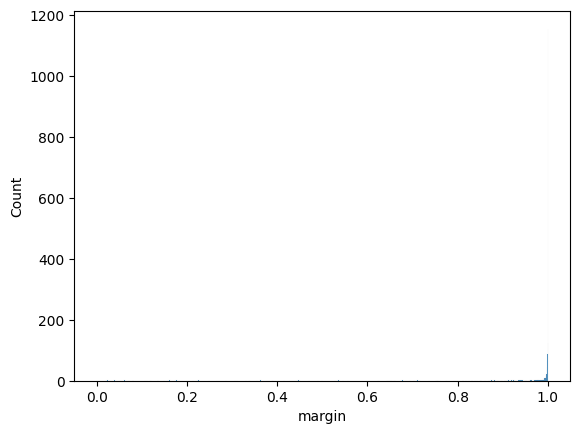

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(dpo_df['margin'])
plt.show()

In [82]:
dpo_df['margin'].describe()

count    2031.000000
mean        0.968466
std         0.131539
min         0.000000
25%         0.997708
50%         0.999816
75%         0.999988
max         0.999999
Name: margin, dtype: float64

In [86]:
len(dpo_df[dpo_df['is_correct'] == False])

50

In [98]:
dpo_df['top5_candidates'][:10].tolist()

[[{'rank': 1,
   'token_id': 17,
   'token': '2',
   'logit': 30.4375,
   'prob': 0.8902146816253662},
  {'rank': 2,
   'token_id': 19,
   'token': '4',
   'logit': 27.8125,
   'prob': 0.06448694318532944},
  {'rank': 3,
   'token_id': 18,
   'token': '3',
   'logit': 26.984375,
   'prob': 0.02817225456237793},
  {'rank': 4,
   'token_id': 16,
   'token': '1',
   'logit': 26.484375,
   'prob': 0.017087338492274284},
  {'rank': 5,
   'token_id': 20,
   'token': '5',
   'logit': 20.0625,
   'prob': 2.7777268769568764e-05}],
 [{'rank': 1,
   'token_id': 16,
   'token': '1',
   'logit': 32.3125,
   'prob': 0.996335506439209},
  {'rank': 2,
   'token_id': 17,
   'token': '2',
   'logit': 26.46875,
   'prob': 0.002887335605919361},
  {'rank': 3,
   'token_id': 18,
   'token': '3',
   'logit': 24.578125,
   'prob': 0.0004359224403742701},
  {'rank': 4,
   'token_id': 19,
   'token': '4',
   'logit': 24.3125,
   'prob': 0.0003342333366163075},
  {'rank': 5,
   'token_id': 20,
   'token': '5',


In [110]:
import numpy as np
import pandas as pd

m = pd.to_numeric(dpo_df["margin"], errors="coerce")

qs = np.arange(0.1, 1.0, 0.1)
qvals = m.quantile(qs)

print(qvals.to_frame("margin_quantile"))

     margin_quantile
0.1         0.976541
0.2         0.995709
0.3         0.998641
0.4         0.999511
0.5         0.999816
0.6         0.999919
0.7         0.999977
0.8         0.999993
0.9         0.999997


In [101]:
dpo_df.groupby("is_correct")["margin"].describe()

,count,mean,std,min,25%,50%,75%,max
is_correct,,,,,,,,
False,50.0,0.489123,0.359105,0.0,0.151278,0.396594,0.869378,0.995731
True,1981.0,0.980565,0.092733,0.0,0.998114,0.999834,0.999989,0.999999


In [108]:
dpo_df.groupby(["is_correct", "choices_len"])["margin"].describe()

count      mean       std       min       25%  \
is_correct choices_len                                                   
False      4              45.0  0.481143  0.367484  0.000000  0.136194   
           5               5.0  0.560939  0.295064  0.286102  0.390407   
True       4             747.0  0.959025  0.132859  0.000000  0.990799   
           5            1234.0  0.993603  0.051753  0.023415  0.999805   

                             50%       75%       max  
is_correct choices_len                                
False      4            0.402413  0.881730  0.995731  
           5            0.390776  0.756370  0.981042  
True       4            0.998227  0.999586  0.999993  
           5            0.999970  0.999996  0.999999

In [105]:
dpo_df['answer_token_prob'].describe()

count    2031.000000
mean        0.981106
std         0.079558
min         0.365699
25%         0.998633
50%         0.999886
75%         0.999993
max         1.000000
Name: answer_token_prob, dtype: float64

In [107]:
dpo_df[dpo_df['answer_token_prob'] < 0.995]

,id,paragraph,question,question_plus,choices,choices_len,answer,predicted_answer,is_correct,generated_text,answer_token,answer_token_prob,top5_candidates,margin,prompt
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,NaN,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",4,2,2,True,<think>\n\n</think>\n\n2,2,0.890215,"[{'rank': 1, 'token_id': 17, 'token': '2', 'lo...",0.825728,<|im_start|>system\n당신은 **지식 추론(Knowledge Infe...
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,NaN,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,4,4,True,<think>\n\n</think>\n\n4,4,0.493203,"[{'rank': 1, 'token_id': 19, 'token': '4', 'lo...",0.225053,<|im_start|>system\n당신은 **지식 추론(Knowledge Infe...
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,NaN,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",4,2,2,True,<think>\n\n</think>\n\n2,2,0.779389,"[{'rank': 1, 'token_id': 17, 'token': '2', 'lo...",0.643952,<|im_start|>system\n당신은 **지식 추론(Knowledge Infe...
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,NaN,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",4,3,3,True,<think>\n\n</think>\n\n3,3,0.573542,"[{'rank': 1, 'token_id': 18, 'token': '3', 'lo...",0.355850,<|im_start|>system\n당신은 **지식 추론(Knowledge Infe...
5,generation-for-nlp-431,(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르...,(가) 국가에 대한 설명으로 옳은 것은?,NaN,"[나 당연합군의 공격으로 멸망하였다 ., 9주 5소경의 지방 행정 구역을 두었다 ....",4,3,3,True,<think>\n\n</think>\n\n3,3,0.778191,"[{'rank': 1, 'token_id': 18, 'token': '3', 'lo...",0.647122,<|im_start|>system\n당신은 **지식 추론(Knowledge Infe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,generation-for-nlp-2816,부동산 전문가들은 전·월세 대책 이후 거래와 투자심리가 위축됐다는 점엔 대체로 의견...,부동산 전문가들이 올해 부동산 시장에 대해 예상하는 주된 이유는 무엇인가?,NaN,"[정부의 내수 활성화 정책, 전셋값 상승세, 금리 인하, 소형 주택 가격 하락, 부...",5,1,1,True,<think>\n\n</think>\n\n1,1,0.511315,"[{'rank': 1, 'token_id': 16, 'token': '1', 'lo...",0.023415,<|im_start|>system\n당신은 논리적인 **텍스트 분석 및 독해 전문가...
1969,generation-for-nlp-2827,서울 강남 지역에 남아 있는 마지막 무허가 집단거주지인 구룡마을(28만6929㎡) ...,구룡마을 개발이 백지화된 이유로 가장 적절한 것은 무엇인가?,NaN,"[서울시와 강남구 간의 갈등, 주민들의 반대, 부동산 시장의 침체, 개발계획 수립 ...",5,4,4,True,<think>\n\n</think>\n\n4,4,0.934773,"[{'rank': 1, 'token_id': 19, 'token': '4', 'lo...",0.870160,<|im_start|>system\n당신은 논리적인 **텍스트 분석 및 독해 전문가...
1994,generation-for-nlp-2855,공급 과잉 논란 속에 배후 임대수요 확보 여부가 ‘수익형 부동산’인 오피스텔 선택 ...,오피스텔 투자에서 안정적인 임대수요를 확보하기 위해 가장 중요한 요소는 무엇인가?,NaN,"[공급 과잉 여부, 업무 밀집지역, 교통 여건, 임대료 수준, 세입자의 연령대]",5,2,2,True,<think>\n\n</think>\n\n2,2,0.991525,"[{'rank': 1, 'token_id': 17, 'token': '2', 'lo...",0.983466,<|im_start|>system\n당신은 논리적인 **텍스트 분석 및 독해 전문가...
2013,generation-for-nlp-2878,중국인 관광객이 국내 면세점 이용액에서 처음으로 한국인을 앞섰다.28일 관세청이 국...,중국인이 국내 면세점에서 처음으로 한국인을 앞선 시점은 언제인가?,NaN,"[2010년, 2015년, 2021년, 2022년, 2023년]",5,5,5,True,<think>\n\n</think>\n\n5,5,0.926345,"[{'rank': 1, 'token_id': 20, 'token': '5', 'lo...",0.876478,<|im_start|>system\n당신은 논리적인 **텍스트 분석 및 독해 전문가...


In [119]:
thr_true = dpo_df.loc[dpo_df.is_correct, "margin"].quantile(0.2)
soft_true = dpo_df[(dpo_df.is_correct) & (dpo_df.margin <= thr_true)]

In [120]:
soft_true['answer_token_prob'].describe()

count    397.000000
mean       0.942596
std        0.115466
min        0.382857
25%        0.952953
50%        0.991295
75%        0.996187
max        0.998230
Name: answer_token_prob, dtype: float64

In [123]:
incorrect_df = dpo_df[dpo_df.is_correct == False]
soft_true = dpo_df[(dpo_df.is_correct) & (dpo_df.margin <= 0.995)]


In [128]:
dpo_df.iloc[0,:].to_dict()

{'id': 'generation-for-nlp-425',
 'paragraph': '상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.',
 'question': '상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?',
 'question_plus': nan,
 'choices': ['ㄱ, ㄴ', 'ㄱ, ㄷ', 'ㄴ, ㄹ', 'ㄷ, ㄹ'],
 'choices_len': 4,
 'answer': '2',
 'predicted_answer': '2',
 'is_correct': True,
 'generated_text': '<think>\n\n</think>\n\n2',
 'answer_token': '2',
 'answer_token_prob': 0.8902146816253662,
 'top5_candidates': [{'rank': 1,
   'token_id': 17,
   'token': '2',
   'logit': 30.4375,
   'prob': 0.8902146816253662},
  {'rank': 2,
   'token_id': 19,
   'token': '4',
   'logit': 27.8125,
   'prob': 0.06448694318532944},
  {'rank': 3,
   'token_id': 18,
   'token': '3',
   '

In [ ]:
import json, re
from pathlib import Path
from typing import List, Dict, Any, Optional

def wrap_answer(d: str) -> str:
    return f"<think>\n\n</think>\n\n{d}"

def normalize_digit(token_text: str, k: int) -> Optional[str]:
    if token_text is None:
        return None
    m = re.findall(rf"[1-{k}]", str(token_text))
    return m[-1] if m else None

def pick_rejected_digits(row: Dict[str, Any], num_rej: int) -> List[str]:
    k = int(row["choices_len"])
    gold = str(row["answer"])

    picked: List[str] = []

    # 1) top5_candidates에서 1..K 숫자만 뽑기
    for c in (row.get("top5_candidates") or []):
        d = normalize_digit(c.get("token"), k)
        if d is None or d == gold or d in picked:
            continue
        picked.append(d)
        if len(picked) >= num_rej:
            return picked

    # 2) 부족하면 fallback으로 1..K 중 gold 제외로 채우기
    for d in map(str, range(1, k + 1)):
        if d == gold or d in picked:
            continue
        picked.append(d)
        if len(picked) >= num_rej:
            break

    return picked

def make_pairs_for_row(row: Dict[str, Any], num_rej: int, source: str) -> List[Dict[str, Any]]:
    prompt = row["prompt"]          # 이미 <|im_start|>assistant\n 까지 포함된 prompt
    gold = str(row["answer"])
    k = int(row["choices_len"])

    rejected_digits = pick_rejected_digits(row, num_rej=num_rej)

    pairs = []
    for rd in rejected_digits:
        pairs.append({
            "prompt": prompt,
            "chosen": wrap_answer(gold),
            "rejected": wrap_answer(rd),
            "meta": {
                "id": row.get("id"),
                "choices_len": k,
                "source": source,
                "margin": row.get("margin"),
                "gold": gold,
                "rejected_digit": rd,
                "is_correct": bool(row.get("is_correct")),
            }
        })
    return pairs

def build_dpo_dataset(dpo_df, margin_thr: float = 0.995) -> List[Dict[str, Any]]:
    incorrect_df = dpo_df[dpo_df["is_correct"] == False]
    soft_true_df = dpo_df[(dpo_df["is_correct"] == True) & (dpo_df["margin"] <= margin_thr)]

    rows: List[Dict[str, Any]] = []

    # incorrect: 4지=2개, 5지=3개
    for _, r in incorrect_df.iterrows():
        row = r.to_dict()
        k = int(row["choices_len"])
        num_rej = 2 if k == 4 else 3
        rows.extend(make_pairs_for_row(row, num_rej=num_rej, source="incorrect"))

    # soft_true: 1개
    for _, r in soft_true_df.iterrows():
        row = r.to_dict()
        rows.extend(make_pairs_for_row(row, num_rej=1, source="soft_true"))

    print(f"incorrect rows: {len(incorrect_df)}")
    print(f"soft_true rows: {len(soft_true_df)}")
    print(f"total DPO pairs: {len(rows)}")
    return rows

def save_jsonl(rows: List[Dict[str, Any]], out_path: str):
    out_path = str(Path(out_path))
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "w", encoding="utf-8") as f:
        for x in rows:
            f.write(json.dumps(x, ensure_ascii=False) + "\n")
    print("Saved:", out_path)

# 사용 예시
# 
# save_jsonl(dpo_rows, "./data/dpo_train.jsonl")

In [134]:
dpo_rows = build_dpo_dataset(dpo_df, margin_thr=0.995)
dpo_rows
output_path = project_root / "data/dpo_dataset.jsonl"
save_jsonl(dpo_rows, output_path)

incorrect rows: 50
soft_true rows: 327
total DPO pairs: 432
Saved: /data/ephemeral/pro-nlp-generationfornlp-nlp-13/data/dpo_dataset.jsonl


In [ ]:
import json
from sklearn.model_selection import train_test_split

# JSONL 로드
with open(output_path, "r", encoding="utf-8") as f:
    dpo_data = [json.loads(line) for line in f]

print(f"Total DPO samples: {len(dpo_data)}")

# Train/Eval 분리 (80:20)
train_data, eval_data = train_test_split(
    dpo_data,
    test_size=0.1,
    random_state=42,
)

print(f"Train: {len(train_data)}, Eval: {len(eval_data)}")

# Train 저장
train_path = project_root / "data" / "dpo_train.jsonl"
with open(train_path, "w", encoding="utf-8") as f:
    for item in train_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")
print("Saved: ./data/dpo_train.jsonl")

# Eval 저장
eval_path = project_root / "data" / "dpo_eval.jsonl"
with open(eval_path, "w", encoding="utf-8") as f:
    for item in eval_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")
print("Saved: ./data/dpo_eval.jsonl")


Total DPO samples: 432
Train: 388, Eval: 44
Saved: ./data/dpo_train.jsonl
Saved: ./data/dpo_eval.jsonl


: 